# **Import Libs**

In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

In [4]:
#Import Libs
from tensorflow.keras.preprocessing.image import load_img

#Import custom modules
from utils.cam_utils import get_img_array, get_superimposed_image, gen_cam
from utils.cam_utils import get_change_input_func, change_input_shape2
from utils.load_utils import init_models

#Other modules
import matplotlib.pyplot as plt
import numpy as np

#Supress Tensorflow Unnecessary Warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
#Define Constants
IMAGE_SIZE = (256,256)
FONT_SIZE = 12
DPI = 600

#Data paths
VAL_DATA_PATH = 'ds/val/'
TEST_DATA_PATH = 'ds/test/'

In [6]:
#Load {index:class} dictionary Function
def index_class_dict():
	file_names = os.listdir('ds/test/')
	file_names = sorted(file_names)
	index_class = {}
	for i in range(len(file_names)):
		index_class[i] = file_names[i]

	return index_class

#Softmax Function
def softmax(arr):
	for i in range(len(arr)):
		ex =np.exp(arr[i])
		arr[i] = ex/np.sum(ex)
	return arr

#Save Figure Function
def savefigure(directory, fig_name):
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(directory + '/' + fig_name + '.tiff', bbox_inches='tight', dpi=DPI, format='tiff')

In [7]:
#Load required model
MODEL_NAME = 'KD-EfficientNetB0'
all_models = init_models([MODEL_NAME])
model = all_models[MODEL_NAME]['model']

#Set preprocessing and rescale
preprocess_func = all_models[MODEL_NAME]['preprocess_func']
rescale = all_models[MODEL_NAME]['rescale']

#change_input_shape and activation_layer_index
if MODEL_NAME in ['Custom-CNN', 'KD-Custom-CNN']:
    change_input_shape = change_input_shape2
    activation_layer_index = -3
else:
    change_input_shape = get_change_input_func(all_models[MODEL_NAME]['api_func'])
    activation_layer_index = -4

#Load {index:class} dict
index_class = index_class_dict()

[INFO] Loading Model: KD-EfficientNetB0


[INFO] SHOW ORIGINAL IMAGE


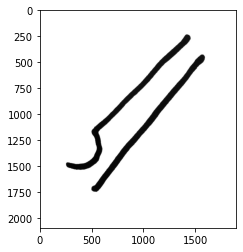

In [8]:
print("[INFO] SHOW ORIGINAL IMAGE")
IMAGE_PATH = 'ds/test/soonerorlater/soonerorlater15.jpg'

#Load and preprocess Image
image = load_img(IMAGE_PATH)
image_array = get_img_array(image, IMAGE_SIZE, preprocess_func, rescale)
plt.imshow(image)
plt.show()

In [9]:
#Get predictions
preds = model.predict(np.expand_dims(image_array, axis=0))
preds = softmax(preds)
pred_index = np.argmax(preds[0])
score = "{0:.3f}%".format(preds[0][pred_index]*100)
print("[INFO] MODEL PREDICTION CLASS: ", index_class[pred_index] )

[INFO] MODEL PREDICTION CLASS:  soonerorlater


In [10]:
print("[INFO] GENERATING CAMS")
#Grad-Cam
gradcam_heatmap = gen_cam('gradcam', model, image_array, label_index=pred_index, activation_layer_index=activation_layer_index)
#Grad-Cam++
gradcampp_heatmap = gen_cam('gradcampp', model, image_array, label_index=pred_index, activation_layer_index=activation_layer_index)
#FasterScore-Cam++
scorecam_heatmap = gen_cam('scorecam', model, image_array, label_index=pred_index, activation_layer_index=activation_layer_index)
#CAMERAS
cameras_heatmap = gen_cam('cameras', model, image_array, label_index=pred_index, activation_layer_index=activation_layer_index, 
                                                                                            change_input_shape=change_input_shape)

print("[INFO] SUPER-IMPOSING CAM HEATMAPS ON ORIGINAL IMAGES")
#Load Original Image
org_image = load_img(IMAGE_PATH)
org_image = get_img_array(org_image, IMAGE_SIZE)
#Superimpose heatmap
gradcam_super_img = get_superimposed_image(org_image, gradcam_heatmap)
gradcampp_super_img = get_superimposed_image(org_image, gradcampp_heatmap)
scorecam_super_img = get_superimposed_image(org_image, scorecam_heatmap)
cameras_super_img = get_superimposed_image(org_image, cameras_heatmap)

[INFO] GENERATING CAMS
[INFO] SUPER-IMPOSING CAM HEATMAPS ON ORIGINAL IMAGES


[INFO] PLOTTING CAMS
[INFO] SAVING CAMS TO OUTPUT PATH



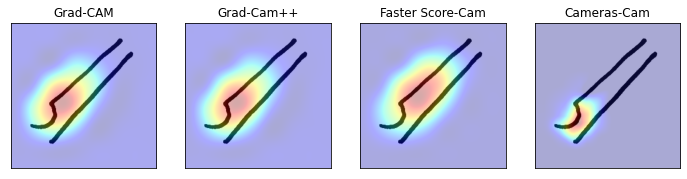

In [11]:
OUTPUT_PATH = 'out/Cams/'

print("[INFO] PLOTTING CAMS")
plt.figure(figsize=(12, 12))

plt.subplot(1, 4, 1)
plt.imshow(gradcam_super_img)
plt.xticks([])
plt.yticks([])
plt.title("Grad-CAM", fontsize=FONT_SIZE)

plt.subplot(1, 4, 2)
plt.imshow(gradcampp_super_img)
plt.xticks([])
plt.yticks([])
plt.title("Grad-Cam++", fontsize=FONT_SIZE)

plt.subplot(1, 4, 3)
plt.imshow(scorecam_super_img)
plt.xticks([])
plt.yticks([])
plt.title("Faster Score-Cam", fontsize=FONT_SIZE)

plt.subplot(1, 4, 4)
plt.imshow(cameras_super_img)
plt.xticks([])
plt.yticks([])
plt.title("Cameras-Cam", fontsize=FONT_SIZE)

print("[INFO] SAVING CAMS TO OUTPUT PATH\n")
savefigure(OUTPUT_PATH, 'CAM-' + MODEL_NAME + '-' + index_class[pred_index])
plt.show()